In [ ]:
#yet another new script - this time, now that we have hovmoller plots of frequency and intensity for arbitrary time
#periods, go and calculate their significance

#In the case of frequency changes, we can calculate the change in significance analytically because a binary variable
#obeys a Bernoulli distribution, with variance p*(1-p) and standard error (p*(1-p)/n)^(1/2),

#Another really important factor is that we'll eventually have to calculate the autocorrelation
#in other words, the probability of seeing a rainband on one day is higher than usual if we've just seen one
#this will lower the effective sample size n = N/tau with N as total observations.

#that correction is now performed with RDA_frequency_autocorrelation.ipynb.

In [1]:
import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
#import masked arrays - important because intensity shows up as a NaN at some points
%matplotlib notebook
import numpy.ma as ma
import scipy.stats as st

In [2]:
## LOAD FROM NETCDF FILE ##
savefile = "RDA_hov_periods"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + savefile + ".nc"
hovnc = nc.Dataset(hovname, "r")

#populate lists with intensity occupancy plots for each different time period (periods given below)
p1_beg = [1951,1980]
p1_end = [1979,1993]
p2_beg = [1980,1994]
p2_end = [2007,2007]

#in this case, we're just going to load the smoothed plots of hovmoller frequency
lats_1_p1 = []
lats_p1 = []

lats_1_p2 = []
lats_p2 = []


for p1_b, p1_e, p2_b, p2_e in zip(p1_beg, p1_end, p2_beg, p2_end):

    years_p1= str(p1_b-1900) + str("{0:0=2d}".format((p1_e-1900)%100))
    print(years_p1)
    years_p2= str(p2_b-1900) + str("{0:0=2d}".format((p2_e-1900)%100))
    print(years_p2)
    
    lats_1_p1.append(hovnc['lat_1_hov_smth_' + years_p1][:])
    lats_p1.append(hovnc['lat_hov_smth_' + years_p1][:])
    
    lats_1_p2.append(hovnc['lat_1_hov_smth_' + years_p2][:])
    lats_p2.append(hovnc['lat_hov_smth_' + years_p2][:])
    
hovnc.close()

5179
8007
8093
9407


<IPython.core.display.Javascript object>


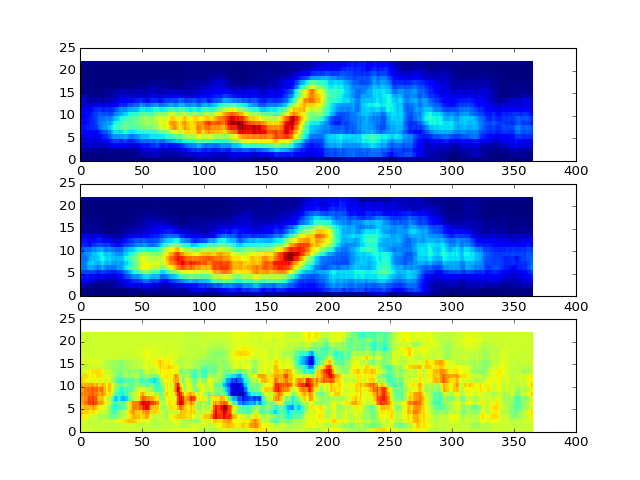

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(lats_1_p1[0].T)

ax1 = fig.add_subplot(312)
plt.pcolormesh(lats_1_p2[0].T)

ax1 = fig.add_subplot(313)
plt.pcolormesh(lats_1_p2[0].T-lats_1_p1[0].T)

<IPython.core.display.Javascript object>


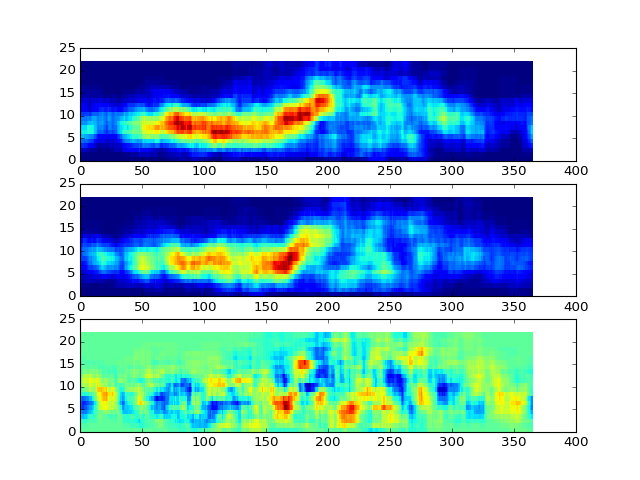

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(lats_1_p1[1].T)

ax1 = fig.add_subplot(312)
plt.pcolormesh(lats_1_p2[1].T)

ax1 = fig.add_subplot(313)
plt.pcolormesh(lats_1_p2[1].T-lats_1_p1[1].T)

In [4]:
#returns the standard error for a Bernoulli variable with probability of success p and number
#of trials n.
def bernoulli_std(p, n):
    s = (p*(1-p)/n)**.5
    return s

#performs bernoulli_std for each point in 2D numpy array F, returns array of standard deviations
#F is a probability distributed between 0 and 1.
def freq_std(F, years, dayrange, latrange):
    S = np.zeros(F.shape)
    ll = (latrange-1)/2
    
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            
            #have to adjust number of samples if we're at the edges
            lrange = int(min(S.shape[1]-1,j+ll) - max(0,j-ll) + 1)
            nn = years*dayrange*lrange
            S[i,j] = bernoulli_std(F[i,j],nn)
    
    return S

In [5]:
## the second argument in freq_std is the number of years in the sample - needs to change
p1_beg = [1951,1980]
p1_end = [1979,1993]
p2_beg = [1980,1994]
p2_end = [2007,2007]

#find standard deviation for each day and bin
lats_1_p1_std = [ freq_std(x, ye-yb+1, 15, 5) for x, yb, ye in zip(lats_1_p1, p1_beg, p1_end) ]
lats_p1_std = [ freq_std(x, ye-yb+1, 15, 5) for x, yb, ye in zip(lats_p1, p1_beg, p1_end) ]

lats_1_p2_std = [ freq_std(x, ye-yb+1, 15, 5) for x, yb, ye in zip(lats_1_p2, p2_beg, p2_end) ]
lats_p2_std = [ freq_std(x, ye-yb+1, 15, 5) for x, yb, ye in zip(lats_p2, p2_beg, p2_end) ]

In [6]:
## VERIFICATION CELL - checking that we get sane results when we compare 57-year standard deviations with the
#estimates with variable years from the previous cell.
tst = [ freq_std(x, 57, 15, 5) for x in lats_1_p1 ]
print(tst[1][200,:])
print(lats_1_p1_std[1][200,:])
print(lats_1_p1_std[1][200,:]/tst[1][200,:])
print(1.402**2)
print(57/29)

[ 0.00111074  0.00176047  0.00187354  0.00203868  0.00209063  0.00223868
  0.00193027  0.00203868  0.00203868  0.00233171  0.00296265  0.00331825
  0.00349392  0.0036051   0.00357771  0.00319446  0.002783    0.00246404
  0.00219054  0.00181492  0.00166079  0.00221083]
[ 0.00224122  0.00355224  0.00378039  0.0041136   0.00421842  0.00451716
  0.00389485  0.0041136   0.0041136   0.00470487  0.00597797  0.0066955
  0.00704995  0.00727429  0.00721903  0.00644571  0.00561547  0.00497188
  0.00442002  0.00366211  0.0033511   0.00446097]
[ 2.01777813  2.01777813  2.01777813  2.01777813  2.01777813  2.01777813
  2.01777813  2.01777813  2.01777813  2.01777813  2.01777813  2.01777813
  2.01777813  2.01777813  2.01777813  2.01777813  2.01777813  2.01777813
  2.01777813  2.01777813  2.01777813  2.01777813]
1.9656039999999997
1.9655172413793103


<IPython.core.display.Javascript object>


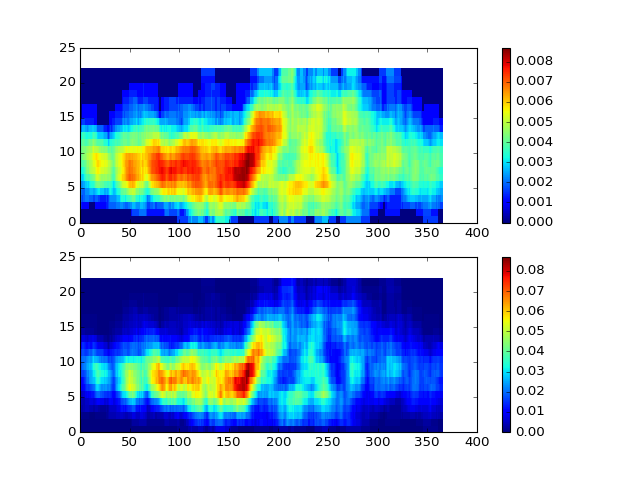

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.pcolormesh(lats_1_p2_std[1].T)
plt.colorbar()

ax2 = fig.add_subplot(212)
plt.pcolormesh(lats_1_p2[1].T)
plt.colorbar()


In [9]:
bernoulli_std(.7, 57*15*3)

0.009048278567177282

In [11]:
## CALCULATE CHANGES IN FREQUENCY BETWEEN TIME PERIODS
lats_1_diff = []
lats_diff = []

lats_1_Z = []
lats_Z = []

lats_1_pval = []
lats_pval = []

for lat_p1, lat_p1_std, lat_p2, lat_p2_std in zip(lats_1_p1, lats_1_p1_std, lats_1_p2, lats_1_p2_std):
    
    lats_1_diff.append(lat_p2-lat_p1)
    Zscore = (lat_p2-lat_p1)/((lat_p1_std**2+lat_p2_std**2)**.5)
    lats_1_Z.append(ma.array(Zscore, mask = np.isnan(Zscore)))
    lats_1_pval.append(ma.array(st.norm.cdf(Zscore), mask = np.isnan(Zscore)))
    
for lat_p1, lat_p1_std, lat_p2, lat_p2_std in zip(lats_p1, lats_p1_std, lats_p2, lats_p2_std):
    
    lats_diff.append(lat_p2-lat_p1)
    Zscore = (lat_p2-lat_p1)/((lat_p1_std**2+lat_p2_std**2)**.5)
    lats_Z.append(ma.array(Zscore, mask = np.isnan(Zscore)))
    lats_pval.append(ma.array(st.norm.cdf(Zscore), mask = np.isnan(Zscore)))


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1665: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1665: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1666: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


In [34]:
## SAVE FREQUENCY DIFFERENCES AND P-VALUES AS NETCDF
outfilename = "RDA_freq_diff.nc"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
fullname = ferretpath + outfilename

##the following is only to make sure that we don't exceed the bounds of the number of rows of actual data.
if os.path.isfile(fullname):
    os.remove(fullname)
    
outfile = nc.Dataset(fullname, 'w')

#use same years as chosen above:
#p1_beg = [1951,1980]
#p1_end = [1979,1993]
#p2_beg = [1980,1994]
#p2_end = [2007,2007]

#create dimensions in NetCDF file
days_dim = outfile.createDimension('time', None)
lat_dim = outfile.createDimension('lat', 22)
dim_tuple = ("time","lat")

#run through loop and save all differences of interest, as well as p-values
for p1_b, p1_e, p2_b, p2_e, lat_1_diff, lat_diff, lat_1_Z, lat_Z, lat_1_pval, lat_pval in \
                            zip(p1_beg, p1_end, p2_beg, p2_end, lats_1_diff, \
                            lats_diff, lats_1_Z, lats_Z, lats_1_pval, lats_pval):
    
    #convoluted line of code below guarantees that 2007 will become '07' and not '7'
    yrs_p1 = str(p1_b-1900) + str("{0:0=2d}".format((p1_e-1900)%100))
    yrs_p2 = str(p2_b-1900) + str("{0:0=2d}".format((p2_e-1900)%100))
    years = yrs_p2 + '_' + yrs_p1
    print(years)

    #create variables inside netCDF file
    lats_1_diff_out = outfile.createVariable("lat_1_diff_" + years, 'f8', dim_tuple)
    lats_diff_out = outfile.createVariable("lat_diff_" + years, 'f8', dim_tuple)
    
    lats_1_Z_out = outfile.createVariable("lat_1_Z_" + years, 'f8', dim_tuple)
    lats_Z_out = outfile.createVariable("lat_Z_" + years, 'f8', dim_tuple)
    
    lats_1_pval_out = outfile.createVariable("lat_1_pval_" + years, 'f8', dim_tuple)
    lats_pval_out = outfile.createVariable("lat_pval_" + years, 'f8', dim_tuple)
    
    
    #fill with actual values
    lats_1_diff_out[:] = lat_1_diff
    lats_diff_out[:] = lat_diff
    
    lats_1_Z_out[:] = lat_1_Z
    lats_Z_out[:] = lat_Z
    
    lats_1_pval_out[:] = lat_1_pval
    lats_pval_out[:] = lat_pval

outfile.close()


8007_5179
9407_8093


In [31]:
outfile.close()

In [12]:
## another testing cell - demonstrates that we have to use masked array to save the results of Z-score to p-value conversion.

print(lats_1_diff[0][0,:])
print(lats_1_Z[0][0,:])
qq = st.norm.cdf(lats_1_Z[0])

print(qq[0,:])

[  0.00000000e+00   2.05254516e-05   1.51067323e-03   3.08702791e-03
   5.02463054e-03   3.31691297e-03   5.76354680e-03   4.35139573e-03
   7.06075534e-03   5.68144499e-03   6.51888342e-03   4.05582923e-03
   3.99014778e-03  -2.95566502e-04  -8.53858785e-04   1.64203612e-05
   1.64203612e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[-- 0.024814210298163827 0.8930204821348574 1.1323419451092953
 1.6583721607407012 0.9051795630440546 1.4312658798248683 1.088341496630911
 1.9232475801391204 1.5131702821605622 1.9177916530020354
 1.4071836791622485 1.5551761138550508 -0.13825579370583868
 -0.5796191750169775 0.024812757111693798 0.024812757111693798 -- -- -- --
 --]
[        nan  0.50989842  0.8140769   0.87125465  0.95137881  0.81731487
  0.92382299  0.86177781  0.97277552  0.93488179  0.97243128  0.92031354
  0.94004793  0.44501913  0.28108573  0.50989784  0.50989784         nan
         nan         nan         nan         nan]


//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1665: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1665: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1666: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


<IPython.core.display.Javascript object>


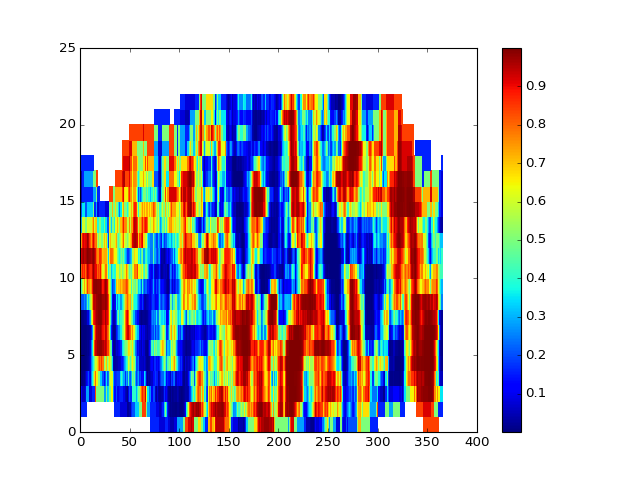

In [13]:
fig,ax = plt.subplots()
plt.pcolormesh(lats_pval[1].T)
plt.colorbar()




//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


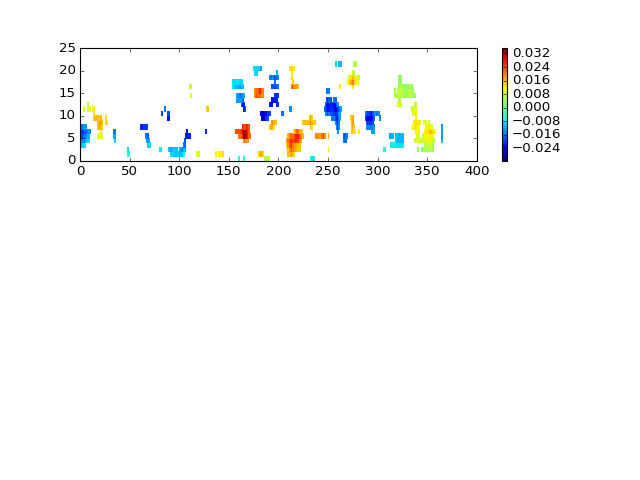

In [26]:
lats_ma = ma.array(lats_diff[1], mask = ~(abs(lats_pval[1]-.5) > .475))

fig = plt.figure()
ax = fig.add_subplot(311)
ax = plt.pcolormesh(lats_ma.T)
plt.colorbar()


In [7]:
qq = freq_std(lats_1_p1[0],57,15,5)

In [38]:
st.norm.cdf(2)

0.97724986805182079

In [14]:
abs(-3)

3

In [8]:
lats_1_p2_std[0][0,:]

array([ 0.        ,  0.00059506,  0.0013443 ,  0.00211942,  0.00241303,
        0.00275407,  0.00309046,  0.00301919,  0.00290876,  0.00290876,
        0.00271393,  0.00227119,  0.00206625,  0.00150226,  0.00095147,
        0.00047608,  0.00047608,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])